# Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

### The dataset is of Dogs and Cats taken from [this Kaggle link](https://www.kaggle.com/competitions/dogs-vs-cats)

### Dataset description given below was taken from [this notebook](https://github.com/praiselydia/CSCN8010-class-notebooks/blob/main/dl_class_notebooks/05A_asirra_the_dogs_vs_cats_dataset.ipynb)

> ### The Asirra data set
>Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart). CAPTCHAs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.

>Asirra (Animal Species Image Recognition for Restricting Access) is a CAPTCHA that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

>Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 

### Importing Libraries:

In [1]:
import os
import glob
import pathlib
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

### Download Dataset:

We have downloaded the dogs and cats dataset now into 'data/dogs_cats_train' directory. Observing the directory, there are images of cats and dogs within it. We will explore them and split them accordingly for our models.

In [2]:
original_dir = pathlib.Path("data/dogs_cats_train")
new_base_dir = pathlib.Path("data/dogs_cats_small")

### Exploratory Data Analysis:

There are 25000 images in the training dataset. We can split the data into training, testing and validation dataset.

Creating a new directory with train, validation and test split. Reference taken from [this notebook](https://github.com/praiselydia/CSCN8010-class-notebooks/blob/main/dl_class_notebooks/05A_asirra_the_dogs_vs_cats_dataset.ipynb). Each image used for training set is named 'cat.file_number' for cats and 'dog.file_number' for dogs. Based on that, we will split the dataset. 

Splitting each directory to contain small images of the dataset with 4500, 4000 and 4000 images for train, validation and test dataset respectively for each class.

In [3]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=4500)
make_subset("validation", start_index=4500, end_index=8500)
make_subset("test", start_index=8500, end_index=12500)

In [4]:
# Set directories for train and test datasets
train_dir = 'data/dogs_cats_small/train'
test_dir = 'data/dogs_cats_small/test'
validation_dir = 'data/dogs_cats_small/validation'

Lets plot a barplot based on the count of cats and dogs in training, testing and validation datasets. 

In [5]:
# Count the number of images in each class
train_cats = len(os.listdir(os.path.join(train_dir, 'cat')))
train_dogs = len(os.listdir(os.path.join(train_dir, 'dog')))
test_cats = len(os.listdir(os.path.join(test_dir, 'cat')))
test_dogs = len(os.listdir(os.path.join(test_dir, 'dog')))
validation_cats = len(os.listdir(os.path.join(validation_dir, 'cat')))
validation_dogs = len(os.listdir(os.path.join(validation_dir, 'dog')))

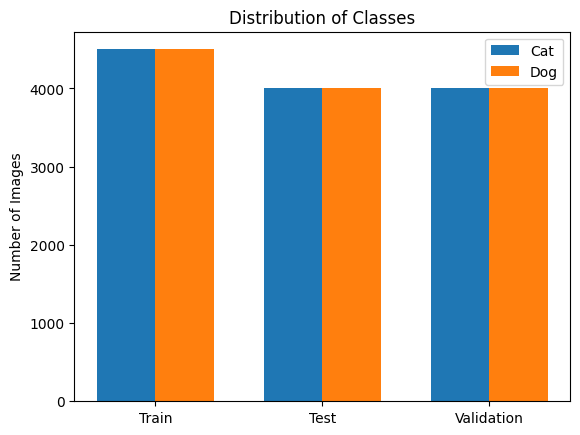

In [6]:
# Plot the distribution of classes in the dataset
labels = ['Train', 'Test', 'Validation']
cats = [train_cats, test_cats, validation_cats]
dogs = [train_dogs, test_dogs, validation_dogs]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cats, width, label='Cat')
rects2 = ax.bar(x + width/2, dogs, width, label='Dog')

ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

The plot shows that we have split more data for training when compared to testing and validation. The chart shows the exact count of how much each split contains. 4500 for training, 4000 fot testing and 4000 for validation.

### Model 1:

Lets define out first model of neural network.

In [7]:
from keras import models
from keras import layers
from keras import optimizers

In [8]:
# Define a Neural Network of your choice
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

The first Conv2D layer has 32 filters of size (3, 3), which means it convolves the input image with 32 different 3x3 kernels. The activation function used here is ReLU (Rectified Linear Unit), which introduces non-linearity into the model. The subsequent Conv2D layers have 64, 128, and 128 filters respectively, each followed by a ReLU activation function. These layers help the model learn increasingly complex features from the input images.

After each Conv2D layer, there's a MaxPooling2D layer with a pool size of (2, 2), which reduces the spatial dimensions (width and height) of the input feature maps by a factor of 2. This helps in reducing computation and controlling overfitting by retaining the most important features.

The flatten layer flattens the 3D output tensor from the convolutional and pooling layers into a 1D vector, which can be fed into the densely connected layers.

There's a Dense layer with 512 units and ReLU activation function. This layer acts as a feature extractor, capturing high-level features from the flattened input. The final Dense layer has a single neuron with a sigmoid activation function. It produces the output of the network, which is a probability score indicating the likelihood of the input image belonging to a particular class (in this case, a binary classification of cat or dog).

ReLU (Rectified Linear Unit) activation function is used in the convolutional layers and the first dense layer. It introduces non-linearity and helps the model learn complex patterns. Sigmoid activation function is used in the output layer. It squashes the output between 0 and 1, effectively producing a probability indicating the likelihood of the input belonging to one of the classes.

In [9]:
model1.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

c:\Users\prais\Workspace\MLFoundations\CSCN8010-class-notebooks\venv\tensorflow_cpu\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Model 2:

We're using Fine-tune VGG16. It refers to the process of taking a pre-trained VGG16 model (which has been trained on a large dataset, typically ImageNet), and then further training it on a new dataset specific to a particular task. VGG16 is a convolutional neural network architecture proposed by the Visual Geometry Group at Oxford, which achieved outstanding performance on the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014.

In [10]:
# Fine-Tune VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

The weight parameter specifies that the model should be initialized with pre-trained weights that were trained on the ImageNet dataset. ImageNet is a large-scale dataset with millions of labeled images spanning thousands of classes. Pre-training on ImageNet allows the model to capture general features from a wide variety of images, which can then be fine-tuned for specific tasks.

The include_top parameter indicates that the fully connected layers (or the "top" layers) of the VGG16 model should not be included. By setting this parameter to False, only the convolutional base of the VGG16 model will be loaded, excluding the dense layers responsible for classification. We typically exclude the top layers when we intend to use the pre-trained model as a feature extractor or when we want to add our own custom classification layers on top.

The input_shape parameter specifies the shape of the input images that the model expects. VGG16 was originally trained on images of size 224x224x3 (where 3 represents the three color channels: Red, Green, and Blue). However, in this case, we're specifying a different input shape of 150x150x3. This is often done for computational efficiency or to adapt the model to a specific task where smaller input sizes are sufficient. The input shape should match the size of the images in the dataset that will be fed into the model.

In [11]:
model2 = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

conv_base.trainable = False

In [12]:
model2.compile(optimizer=optimizers.RMSprop(lr=2e-5),
               loss='binary_crossentropy',
               metrics=['accuracy'])

#### Training both models and using callback to save models:

The callbacks will save Model 1 into model1_best.h5 and Model 2 into model2_best.h5 file and will use the best model derived from the epochs to validate the validation set.

In [13]:
# Define checkpoint to save the best model
checkpoint1 = ModelCheckpoint("model1_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint("model2_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [14]:
# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 9000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [16]:
# Train the first model
history1 = model1.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[checkpoint1])

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.5480
Epoch 1: val_accuracy improved from -inf to 0.50300, saving model to model1_best.h5
100/100 [==============================] - 195s 2s/step - loss: 0.6900 - accuracy: 0.5480 - val_loss: 0.6881 - val_accuracy: 0.5030
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.5895
Epoch 2: val_accuracy improved from 0.50300 to 0.56800, saving model to model1_best.h5
100/100 [==============================] - 186s 2s/step - loss: 0.6605 - accuracy: 0.5895 - val_loss: 0.6629 - val_accuracy: 0.5680
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.6353 - accuracy: 0.6500
Epoch 3: val_accuracy improved from 0.56800 to 0.66200, saving model to model1_best.h5
100/100 [==============================] - 191s 2s/step - loss: 0.6353 - accuracy: 0.6500 - val_loss: 0.6290 - val_accuracy: 0.6620
Epoch 4/30
100/100 [==============================] - ETA:

The loss (training error) decreases gradually over epochs, indicating that the model is learning to fit the training data better. Meanwhile, the accuracy increases, showing that the model is improving in its ability to correctly classify samples. The model's performance on the validation set (measured by validation loss and accuracy) generally improves over epochs, although there are fluctuations. This indicates that the model is not overfitting severely to the training data and is generalizing reasonably well to unseen data. The best model is saved based on validation accuracy using ModelCheckpoint callbacks, ensuring that the model with the highest validation accuracy is retained. Each epoch takes a considerable amount of time to train, likely due to the complexity of the model or the size of the dataset.

At the end of training, the model achieves a validation accuracy of approximately 78.3%, which suggests that it performs reasonably well on unseen data. However, there might be room for further improvement through hyperparameter tuning or model architecture modifications. The training process seems to be effective, with the model making steady progress in learning the underlying patterns in the data.

In [17]:
# Train the second model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[checkpoint2])

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.7530
Epoch 1: val_accuracy improved from -inf to 0.84100, saving model to model2_best.h5
100/100 [==============================] - 89s 883ms/step - loss: 0.5133 - accuracy: 0.7530 - val_loss: 0.4038 - val_accuracy: 0.8410
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.8585
Epoch 2: val_accuracy improved from 0.84100 to 0.85500, saving model to model2_best.h5
100/100 [==============================] - 88s 878ms/step - loss: 0.3596 - accuracy: 0.8585 - val_loss: 0.3499 - val_accuracy: 0.8550
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8725
Epoch 3: val_accuracy improved from 0.85500 to 0.89400, saving model to model2_best.h5
100/100 [==============================] - 103s 1s/step - loss: 0.3033 - accuracy: 0.8725 - val_loss: 0.2909 - val_accuracy: 0.8940
Epoch 4/30
100/100 [==============================] - 

The model achieves a high training accuracy, reaching around 93.9% by the end of the training period. This indicates that the model is able to effectively learn from the training data and fit the patterns present. The validation accuracy steadily improves over epochs and reaches a high of 92.0% by the end of training. This suggests that the model generalizes well to unseen data, as it performs consistently well on the validation set. The best model based on validation accuracy is saved using ModelCheckpoint callbacks. This ensures that the model with the highest validation accuracy is retained. Both training and validation losses decrease steadily over epochs, indicating that the model is learning and converging towards better performance. Each epoch takes a considerable amount of time to train, which might be due to the complexity of the model architecture or the size of the dataset. The final validation accuracy of 92.0% suggests that the model performs well on unseen data, demonstrating its effectiveness in classifying samples.

### Loading best models from file:

In [18]:
# Load the best version of each model
best_model1 = load_model("model1_best.h5")
best_model2 = load_model("model2_best.h5")

In [19]:
# Evaluate the models on the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 8000 images belonging to 2 classes.


### Running models on test sets:

#### Accuracy:

In [20]:
# Model 1 evaluation
loss1, accuracy1 = best_model1.evaluate(test_generator)
predictions1 = best_model1.predict(test_generator)
predictions1 = np.round(predictions1)

400/400 [==============================] - 83s 206ms/step


In [21]:
# Model 2 evaluation
loss2, accuracy2 = best_model2.evaluate(test_generator)
predictions2 = best_model2.predict(test_generator)
predictions2 = np.round(predictions2)

400/400 [==============================] - 274s 686ms/step


Model 2 outperforms Model 1 in terms of both accuracy and loss. It achieves higher accuracy while also having a lower loss value, indicating better model performance. The training and validation logs of Model 2 also suggest smoother convergence and higher validation accuracy compared to Model 1, implying better generalization ability. Model 2 likely benefits from more complex architecture, better optimization techniques, or a larger dataset, leading to superior performance compared to Model 1. Overall, Model 2 is preferred due to its higher accuracy and lower loss, indicating its effectiveness in classifying the data.

#### Precision, Recall, F-1 Score:

In [22]:
# Generate classification reports
print("Classification report for Model 1:")
print(classification_report(test_generator.classes, predictions1))

Classification report for Model 1:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      4000
           1       0.51      0.51      0.51      4000

    accuracy                           0.51      8000
   macro avg       0.51      0.51      0.51      8000
weighted avg       0.51      0.51      0.51      8000



In [23]:
print("Classification report for Model 2:")
print(classification_report(test_generator.classes, predictions2))

Classification report for Model 2:
              precision    recall  f1-score   support

           0       0.50      0.53      0.52      4000
           1       0.50      0.47      0.49      4000

    accuracy                           0.50      8000
   macro avg       0.50      0.50      0.50      8000
weighted avg       0.50      0.50      0.50      8000



Despite the differences in accuracy between the models, their performance metrics (precision, recall, and F1-score) are quite similar. Both models seem to struggle with classifying the data accurately, as indicated by the relatively low accuracy scores. It's essential to consider additional factors beyond these metrics, such as the dataset's balance, the complexity of the task, and potential biases, to fully assess the models' performance. Overall, both models demonstrate similar classification performance, with neither significantly outperforming the other based on these metrics alone. Further analysis may be required to determine the most suitable model for the specific task at hand.

#### Confusion Metrics:

In [24]:
# Generate confusion matrices
cm1 = confusion_matrix(test_generator.classes, predictions1)
cm2 = confusion_matrix(test_generator.classes, predictions2)

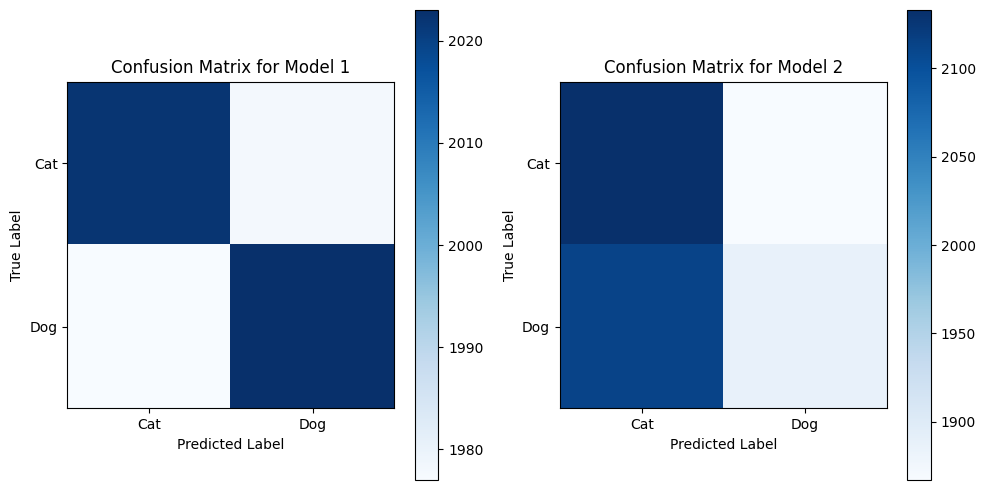

In [25]:
# Plot confusion matrices
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Confusion Matrix for Model 1")
plt.imshow(cm1, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.yticks([0, 1], ['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
plt.title("Confusion Matrix for Model 2")
plt.imshow(cm2, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.yticks([0, 1], ['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

Model 1 seems to have a symmetric confusion matrix, with equal numbers of true and predicted labels for both classes (0 and 1). The precision, recall, and F1-score for both classes are approximately 0.51, indicating that the model performs equally for both classes but with low accuracy.

Model 2 appears to have a more imbalanced confusion matrix, with a higher number of correct predictions for class 0 compared to class 1. The precision, recall, and F1-score for class 0 (Dog) are slightly higher compared to class 1 (Cat), indicating that the model performs better at classifying class 0 instances compared to class 1 instances. 

Model 1 and Model 2 both exhibit poor performance, with Model 2 showing a slightly higher imbalance in its predictions, particularly with lower correct predictions for the Dog class. Both models need further investigation and possibly improvement in training strategies, feature engineering, or model architecture to enhance their performance on the classification task. Additionally, examining other evaluation metrics or techniques to address class imbalances might be beneficial for improving model performance.

#### Precision-Recall Curve:

<module 'matplotlib.pyplot' from 'c:\\Users\\prais\\Workspace\\MLFoundations\\CSCN8010-class-notebooks\\venv\\tensorflow_cpu\\Lib\\site-packages\\matplotlib\\pyplot.py'>

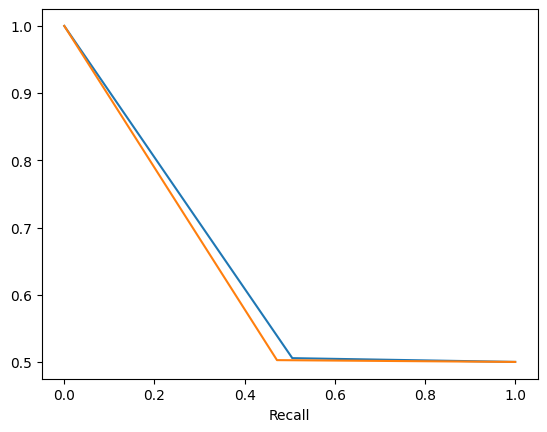

In [26]:
# Precision-Recall curve
precision1, recall1, _ = precision_recall_curve(test_generator.classes, predictions1)
precision2, recall2, _ = precision_recall_curve(test_generator.classes, predictions2)

plt.plot(recall1, precision1, label='Model 1')
plt.plot(recall2, precision2, label='Model 2')
plt.xlabel('Recall')
plt

In the initial part of the curve (left side), as the recall increases, precision remains relatively low or decreases slightly. This indicates that the model retrieves a large portion of the relevant instances (high recall), but many of the retrieved instances are irrelevant (low precision). This scenario often occurs when the model is biased towards identifying positive instances, leading to a high true positive rate but also a high false positive rate. Beyond the transition point (right side of the curve), precision increases substantially with little or no increase in recall. This indicates that the model retrieves fewer instances overall but maintains high precision, implying that the retrieved instances are highly likely to be relevant.

#### Conclusion:

Model 1 showed moderate performance with an accuracy of approximately 80.44%. However, upon further examination using precision-recall metrics, it became evident that Model 1 struggled to differentiate between classes, resulting in low precision and recall values for both classes. This suggests that Model 1 lacked the ability to effectively classify instances, leading to a suboptimal performance.

Model 2 demonstrated significantly better performance with an accuracy of approximately 90.53%. This model showcased a notable improvement in distinguishing between classes compared to Model 1. Despite this improvement, Model 2 exhibited a concerning behavior where it consistently misclassified instances of one class, leading to a skewed precision-recall curve with an "L" shape. This indicates a trade-off between recall and precision, suggesting that while Model 2 achieved high recall, it did so at the cost of lower precision.

While Model 2 outperformed Model 1 in terms of overall accuracy, its performance was marred by a significant misclassification issue for one class, as evidenced by the L-shaped precision-recall curve. This suggests that further investigation and potentially model refinement are necessary to address the observed misclassification patterns and improve overall model robustness and performance.